In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, radon, iradon
import cv2

def add_QUBO(position, values, sinogram_values):
    linear = np.square(values) # ok
    tmp1 = values*np.transpose(values) # ok
    tmp2 = np.ones(np.size(position)) - np.eye(np.size(position)) # ok
    tmp3 = linear - 2*sinogram_values*values
    return np.triu(2*np.multiply(tmp1,tmp2)+np.diag(tmp3.flatten()))

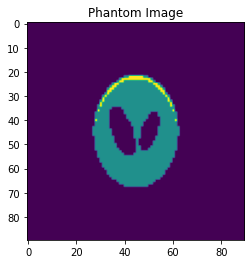

[0.0, 1.0, 2.0]


In [7]:
num_qb = 2
nx = 50
pad = 20
phantom = shepp_logan_phantom() # 400 x 400
phantom = rescale(phantom, nx/400) # 100 x 100
sol_phantom = phantom
phantom = np.pad(phantom, ((pad,pad),(pad,pad)))

dtheta = 180/nx
max_angle = 180
tnp = max_angle/dtheta
theta = np.arange(0, 180, dtheta)

rs_phantom = phantom/np.max(phantom)*(pow(2,num_qb)-2)
fn_phantom = np.round(rs_phantom+0.1, 0)  # 9 means round in Matlab
sino = radon(fn_phantom, theta)

plt.figure()           
plt.title('Phantom Image')
plt.imshow(fn_phantom, vmin=0, vmax=pow(2, num_qb)-2)
plt.show()
sort_ph = sorted(np.unique(fn_phantom))
print(sort_ph)

In [8]:
QM = np.zeros((num_qb*nx**2,num_qb*nx**2))
Fin_Min = 0
num_row = num_qb*nx
for sino_ny in range(0,int(tnp)):
    print(sino_ny)   # 여기 ny 찍기
    temp_theta = [theta[sino_ny]]
    for sino_nx in range(0,nx+2*pad):
#        print(sino_nx)   # 여기 nx 찍기
#        if sino[sino_nx][sino_ny] == 0:
#            continue
        Arr_pos = np.array([])
        Arr_val = np.array([])
        for j in range(0,nx):
            for i in range(0,nx):
                G = np.zeros((nx+2*pad,nx+2*pad))
                G[i+pad][j+pad] = 1
                R = radon(G, temp_theta) 
                for qb in range(0, num_qb):
                    Arr_pos = np.append(Arr_pos, np.array(i+num_row*(j)))
                    Arr_val = np.append(Arr_val, pow(2,qb)*np.array(R[sino_nx][0]))
        sino_val = sino[sino_nx][sino_ny]
        QM = QM + add_QUBO(Arr_pos.reshape(-1,1), Arr_val.reshape(-1,1), sino_val)
        Fin_Min -= sino_val**2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [10]:
T = np.zeros((num_qb*nx**2,1))
for j in range(0,nx):
    for i in range(0,nx):
        Val_fn_pt = fn_phantom[i+pad][j+pad]
        for k in range(0, num_qb):
            temp_val = divmod(Val_fn_pt,2)
            Val_fn_pt = temp_val[0]
            T[i*num_qb + j*num_qb*nx + k] = temp_val[1]
            
tmp1 = np.matmul(np.transpose(T),QM)
tmp2 = np.matmul(tmp1,T)
print('Minimum value as our goal = ', Fin_Min)
print('By using the matrix Q, the obtained value x^TQx = ', tmp2.item())

Minimum value as our goal =  -1559153.7565170014
By using the matrix Q, the obtained value x^TQx =  -1559153.7565170033


In [11]:
def Q_mat(qubits,QM):
    max_d = format(len(str(qubits)), '02')
    
    # linear terms
    Q = {}
    for i in range(qubits): 
        linear_term = format(i + 1, max_d)
        exec("Q.update({('q%s','q%s'):%s})"%(linear_term, linear_term, format(QM[i][i])))

    # quadratic terms
    for i in range(qubits-1):
        for j in range(i+1,qubits):
            if QM[i][j] != 0:
                qdrt1 = format(i + 1, max_d)
                qdrt2 = format(j + 1, max_d)
                exec("Q.update({('q%s','q%s'):%s})"%(qdrt1,qdrt2,format(QM[i][j])))
    return Q

from dwave.system import LeapHybridSampler
sampler = LeapHybridSampler()

qubits = num_qb*nx*nx
Q = Q_mat(qubits, QM)

answer = sampler.sample_qubo(Q)
print(answer)

  q0001 q0002 q0003 q0004 q0005 q0006 q0007 ... q5000          energy num_oc.
0     0     0     0     0     0     0     0 ...     0 -1557675.754199       1
['BINARY', 1 rows, 1 samples, 5000 variables]


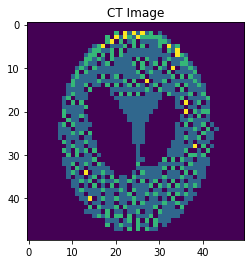

[0.0, 1.0, 2.0, 3.0]


In [12]:
data = list(answer.first[0].values())
CT_phantom = np.zeros((nx,nx))
for j in range(0,nx):
    for i in range(0,nx):
        for k in range(0,num_qb):
            CT_phantom[i][j] = CT_phantom[i][j] + data[i*num_qb + j*num_qb*nx + k]*pow(2,k)
        
plt.figure()           
plt.title('CT Image')
plt.imshow(CT_phantom, vmin=0, vmax=pow(2, num_qb)-1)
plt.show()
sort_ph = sorted(np.unique(CT_phantom))
print(sort_ph)

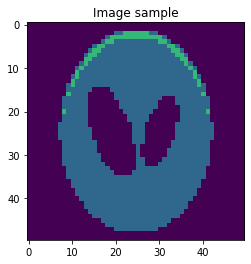

In [13]:
IS_phantom = fn_phantom[pad:nx+pad,pad:nx+pad]
plt.figure()           
plt.title('Image sample')
plt.imshow(IS_phantom, vmin=0, vmax=pow(2, num_qb)-1)
plt.show()

In [14]:
# CT[i,j] = q1 + q2 (not 2q2) <-- alpha1*q1 + (alpha2-alpha1)*q2
QM = np.zeros((num_qb*nx**2,num_qb*nx**2))
Fin_Min = 0
num_row = num_qb*nx
for sino_ny in range(0,int(tnp)):
    print(sino_ny)   # 여기 ny 찍기
    temp_theta = [theta[sino_ny]]
    for sino_nx in range(0,nx+2*pad):
#        print(sino_nx)   # 여기 nx 찍기
#        if sino[sino_nx][sino_ny] == 0:
#            continue
        Arr_pos = np.array([])
        Arr_val = np.array([])
        for j in range(0,nx):
            for i in range(0,nx):
                G = np.zeros((nx+2*pad,nx+2*pad))
                G[i+pad][j+pad] = 1
                R = radon(G, temp_theta) 
                for qb in range(0, num_qb):
                    Arr_pos = np.append(Arr_pos, np.array(i+num_row*(j)))
                    Arr_val = np.append(Arr_val, np.array(R[sino_nx][0]))  # delete pow(2,qb)*
        sino_val = sino[sino_nx][sino_ny]
        QM = QM + add_QUBO(Arr_pos.reshape(-1,1), Arr_val.reshape(-1,1), sino_val)
        Fin_Min -= sino_val**2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [15]:
T = np.zeros((num_qb*nx**2,1))
for j in range(0,nx):
    for i in range(0,nx):
        Val_fn_pt = fn_phantom[i+pad][j+pad]
        for k in range(0, num_qb):
            temp_val = divmod(Val_fn_pt,2)
            Val_fn_pt = temp_val[0]
            T[i*num_qb + j*num_qb*nx + k] = temp_val[1]
            
tmp1 = np.matmul(np.transpose(T),QM)
tmp2 = np.matmul(tmp1,T)
print('Minimum value as our goal = ', Fin_Min)
print('By using the matrix Q, the obtained value x^TQx = ', tmp2.item())

Minimum value as our goal =  -1559153.7565170014
By using the matrix Q, the obtained value x^TQx =  -1549471.6286739744


In [16]:
def Q_mat(qubits,QM):
    max_d = format(len(str(qubits)), '02')
    
    # linear terms
    Q = {}
    for i in range(qubits): 
        linear_term = format(i + 1, max_d)
        exec("Q.update({('q%s','q%s'):%s})"%(linear_term, linear_term, format(QM[i][i])))

    # quadratic terms
    for i in range(qubits-1):
        for j in range(i+1,qubits):
            if QM[i][j] != 0:
                qdrt1 = format(i + 1, max_d)
                qdrt2 = format(j + 1, max_d)
                exec("Q.update({('q%s','q%s'):%s})"%(qdrt1,qdrt2,format(QM[i][j])))
    return Q

from dwave.system import LeapHybridSampler
sampler = LeapHybridSampler()

qubits = num_qb*nx*nx
Q = Q_mat(qubits, QM)

answer = sampler.sample_qubo(Q)
print(answer)

  q0001 q0002 q0003 q0004 q0005 q0006 q0007 ... q5000          energy num_oc.
0     0     0     0     0     0     0     0 ...     0 -1559153.756517       1
['BINARY', 1 rows, 1 samples, 5000 variables]


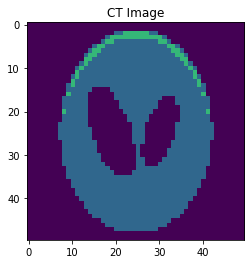

[0.0, 1.0, 2.0]


In [17]:
data = list(answer.first[0].values())
CT_phantom = np.zeros((nx,nx))
for j in range(0,nx):
    for i in range(0,nx):
        for k in range(0,num_qb):
            CT_phantom[i][j] = CT_phantom[i][j] + data[i*num_qb + j*num_qb*nx + k]
        
plt.figure()           
plt.title('CT Image')
plt.imshow(CT_phantom, vmin=0, vmax=pow(2, num_qb)-1)
plt.show()
sort_ph = sorted(np.unique(CT_phantom))
print(sort_ph)

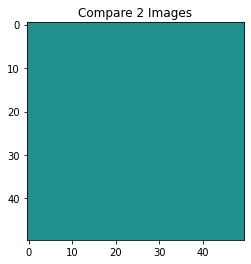

[0.0]


In [18]:
cpr2imgs = IS_phantom - CT_phantom
plt.figure()           
plt.title('Compare 2 Images')
plt.imshow(cpr2imgs, vmin=-1, vmax=1)
plt.show()
sort_ph = sorted(np.unique(cpr2imgs))
print(sort_ph)

In [19]:
print(data)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 